In [7]:
import numpy as np
import os
import cv2
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
from IPython.display import Audio, display

import warnings
warnings.filterwarnings("ignore")
print("libraries imported")

libraries imported


In [8]:
import cv2  # Import OpenCV for resizing the MFCCs

def load_data(data_dir, max_pad_len=128):
    labels, features = [], []
    for label in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, label)
        for file in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file)
            # Load the audio file
            audio, sr = librosa.load(file_path, duration=2.0)
            # Convert to MFCC
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
            # Pad or truncate MFCCs to ensure uniform shape
            if mfccs.shape[1] < max_pad_len:
                pad_width = max_pad_len - mfccs.shape[1]
                mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
            else:
                mfccs = mfccs[:, :max_pad_len]
            # Resize MFCC to 448x448
            mfccs_resized = cv2.resize(mfccs, (448, 448))
            mfccs_resized = np.expand_dims(mfccs_resized, axis=-1)  # Add channel dimension
            features.append(mfccs_resized)
            labels.append(label)
    return np.array(features), np.array(labels)


In [9]:
data_dir = 'C:/Users/aadit/Downloads/archive/input'

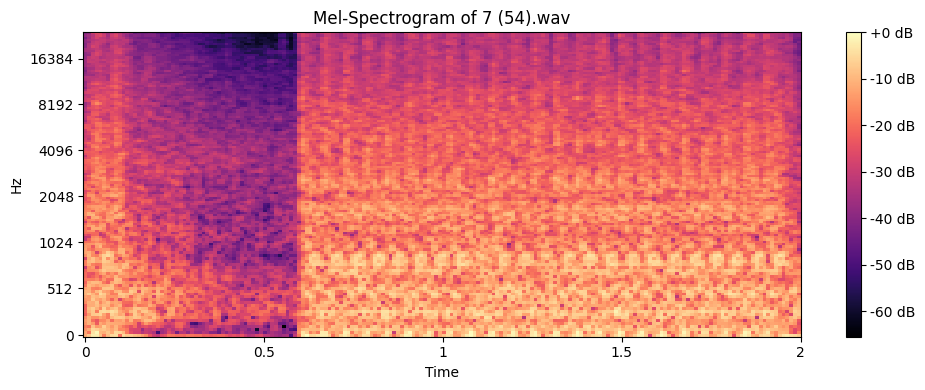

MG-42


In [10]:
import os
import random
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Set the path to your dataset directory
data_dir = 'C:/Users/aadit/Downloads/archive/input' # Replace with your actual dataset path

# Get a list of all categories (folders)
categories = os.listdir(data_dir)

# Select a random category
random_category = random.choice(categories)

# Get a list of all audio files in the selected category
category_path = os.path.join(data_dir, random_category)
audio_files = os.listdir(category_path)

# Select a random audio file
random_audio_file = random.choice(audio_files)
audio_path = os.path.join(category_path, random_audio_file)

# Load the audio file
y, sr = librosa.load(audio_path, sr=None)

# Generate the spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
S_DB = librosa.power_to_db(S, ref=np.max)

# Display the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel-Spectrogram of {random_audio_file}')
plt.tight_layout()
plt.show()
print(random_category)


In [11]:
X, y = load_data(data_dir)

In [12]:
le = LabelEncoder()
y_encoded = to_categorical(le.fit_transform(y))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [14]:
X_train = np.array([librosa.util.fix_length(mfcc, size=448, axis=1) for mfcc in X_train])
X_train = np.repeat(X_train, 3, axis=-1)  # Repeat to make it 3-channel
X_test = np.array([librosa.util.fix_length(mfcc, size=448, axis=1) for mfcc in X_test])
X_test = np.repeat(X_test, 3, axis=-1)  # Repeat to make it 3-channel

In [15]:
# base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(448, 448, 3))

In [16]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(9, activation='softmax')(x)  # Assuming 8 gun types


In [17]:
model = Model(inputs=base_model.input, outputs=predictions)

In [18]:
for layer in base_model.layers:
    layer.trainable = False

In [19]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 448, 448, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 448, 448, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 448, 448, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 224, 224, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 224, 224, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 224, 224, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 112, 112, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 112, 112, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 112, 112, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 112, 112, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 56, 56, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 56, 56, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 56, 56, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 56, 56, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 28, 28, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,816,969 (79.41 MB)

 Trainable params: 792,585 (3.02 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [21]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 367s 21s/step - accuracy: 0.3000 - loss: 2.0665 - val_accuracy: 0.4044 - val_loss: 1.5756
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 359s 21s/step - accuracy: 0.5368 - loss: 1.2714 - val_accuracy: 0.4706 - val_loss: 1.5031
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 586s 35s/step - accuracy: 0.6169 - loss: 1.1069 - val_accuracy: 0.5000 - val_loss: 1.2578
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 519s 31s/step - accuracy: 0.7061 - loss: 0.8022 - val_accuracy: 0.6176 - val_loss: 0.9733
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 520s 31s/step - accuracy: 0.7202 - loss: 0.6795 - val_accuracy: 0.5662 - val_loss: 0.9665
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 461s 27s/step - accuracy: 0.7369 - loss: 0.6474 - val_accuracy: 0.5809 - val_loss: 0.9969
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 482s 29s/step - accuracy: 0.7447 - loss: 0.5924 - val_accuracy: 0.5882 - val_loss: 0.9886
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 506s 30s/step - accuracy: 0.7677 - loss: 0.5134 - val_accuracy: 0.

In [22]:
# for layer in base_model.layers[-10:]:
#     layer.trainable = True


In [23]:
# model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [24]:
# history_fine = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


In [25]:
# test_loss, test_acc = model.evaluate(X_test, y_test)
# print(f'Test Accuracy: {test_acc:.2f}')


In [26]:
model.save('gunshot_classification_mobilenet.h5')


In [27]:
# Save the model in the native Keras format
model.save('gunshot_classification_model.keras')
print("Model saved in Keras format")


Model saved in Keras format


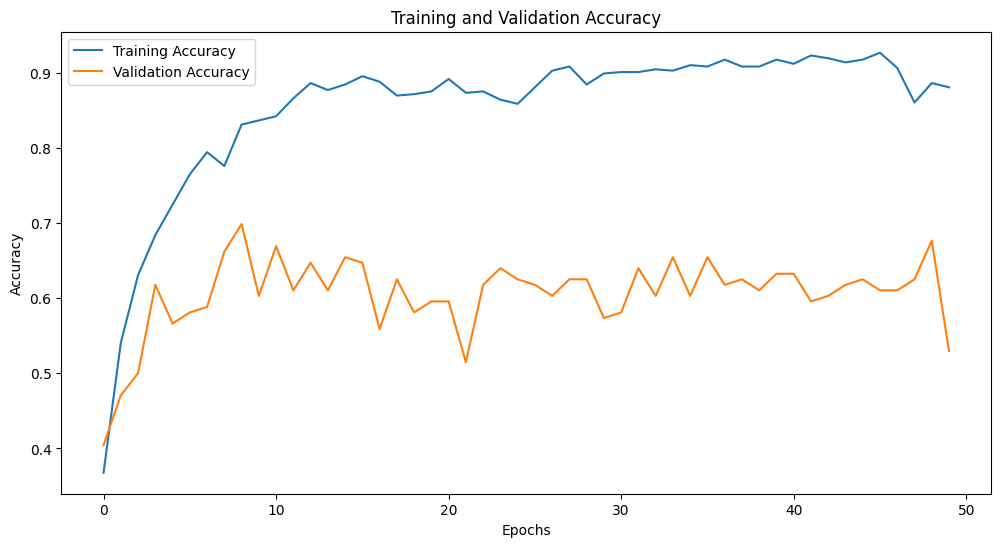

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.plot(history_fine.history['accuracy'], label='Fine-Tuned Training Accuracy')
# plt.plot(history_fine.history['val_accuracy'], label='Fine-Tuned Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [29]:
from tensorflow.image import resize

categories = os.listdir(data_dir)

# Encode the labels
label_encoder = LabelEncoder()
label_encoder.fit(categories)

for i in range(5):
    # Select a random category
    random_category = random.choice(categories)

    # Get a list of all audio files in the selected category
    category_path = os.path.join(data_dir, random_category)
    audio_files = os.listdir(category_path)

    # Select a random audio file
    random_audio_file = random.choice(audio_files)
    audio_path = os.path.join(category_path, random_audio_file)

    # Load the audio file
    y, sr = librosa.load(audio_path, sr=None)

    # Play the audio
    display(Audio(y, rate=sr))

    # Generate MFCCs from the audio file
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    # Reshape MFCCs to fit the model's expected input shape
    mfccs = np.expand_dims(mfccs, axis=-1)
    mfccs = resize(mfccs, [448, 448])
    mfccs = np.concatenate([mfccs] * 3, axis=-1)  # Convert to 3 channels
    mfccs = np.expand_dims(mfccs, axis=0)

    # Predict the category using the model
    predicted_label = model.predict(mfccs)
    predicted_category = label_encoder.inverse_transform([np.argmax(predicted_label)])

    # Print the actual and predicted category
    print(f'Actual Category: {random_category}')
    print(f'Predicted Category: {predicted_category[0]}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Actual Category: AK-12
Predicted Category: M4


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Actual Category: MG-42
Predicted Category: MG-42


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Actual Category: M16
Predicted Category: M4


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Actual Category: M4
Predicted Category: M16


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Actual Category: MP5
Predicted Category: M249


In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


6/6 ━━━━━━━━━━━━━━━━━━━━ 92s 15s/step 
Classification Report:
                  precision    recall  f1-score   support

           AK-12       1.00      0.96      0.98        24
           AK-47       1.00      0.44      0.62         9
IMI Desert Eagle       0.71      0.79      0.75        19
             M16       0.25      0.17      0.20        24
            M249       0.50      0.83      0.62        18
              M4       0.14      0.09      0.11        22
           MG-42       0.53      1.00      0.69        17
             MP5       0.40      0.33      0.36        24
     Zastava M92       1.00      0.79      0.88        14

        accuracy                           0.58       171
       macro avg       0.62      0.60      0.58       171
    weighted avg       0.57      0.58      0.55       171



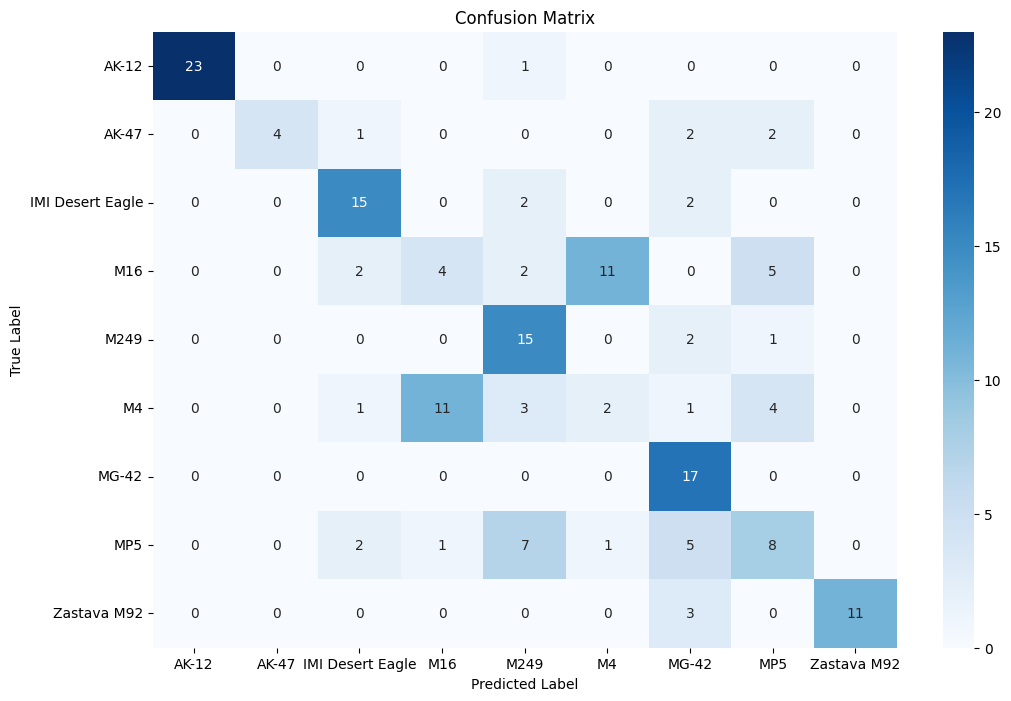

In [32]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=categories))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [33]:
import numpy as np
import librosa
import cv2
from IPython.display import Audio, display
from tensorflow.keras.models import load_model


In [34]:
def detect_gunshot(audio_path, model, categories):
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=None)

    # Generate MFCCs (13 MFCC coefficients)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    # Resize MFCC to fit model input shape
    mfccs_resized = cv2.resize(mfccs, (448, 448))
    mfccs_resized = np.expand_dims(mfccs_resized, axis=-1)  # Add channel dimension
    mfccs_resized = np.concatenate([mfccs_resized] * 3, axis=-1)  # Convert to 3 channels
    mfccs_resized = np.expand_dims(mfccs_resized, axis=0)  # Add batch dimension

    # Make prediction using the trained model
    prediction = model.predict(mfccs_resized)

    # Check if any gunshot category is detected
    if np.argmax(prediction) in range(len(categories)):  # Adjust range based on your actual gun categories
        print(f"Gunshot detected! Predicted gun type: {categories[np.argmax(prediction)]}")
        # Notify authorities or trigger any required actions
        # notify_authorities()
    else:
        print("No gunshot detected.")

    # Play the audio for verification
    display(Audio(y, rate=sr))


In [36]:
# Load the saved model
model_path = 'gunshot_classification_mobilenet.h5'   or 'gunshot_classification_mobilenet.keras'
model = load_model(model_path)

# Define categories (make sure these match your training labels)
categories = ['AK-12', 'AK-47', 'M4', 'IMI Desert Eagle', 'cat', 'dog']


In [41]:
import os
import random
from IPython.display import Audio, display

# Directory containing your mixed audio files
test_audio_dir = 'C:/Users/aadit/Downloads/archive/test'  # Replace with your actual test directory

# Get a list of all .wav files in the test directory
audio_files = [f for f in os.listdir(test_audio_dir) if f.endswith('.wav')]

# Pick 3 random files from the directory
random_audio_files = random.sample(audio_files, 3)

# Define categories (make sure these match your training labels)
categories = ['AK-12', 'AK-47', 'M4', 'IMI Desert Eagle', 'cat', 'dog']

# Loop through the 3 random files and detect gunshots
for random_audio_file in random_audio_files:
    audio_path = os.path.join(test_audio_dir, random_audio_file)

    print(f"Processing file: {random_audio_file}")
    
    # Detect gunshot for the selected audio file
    detect_gunshot(audio_path, model, categories)


Processing file: cat_41.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Gunshot detected! Predicted gun type: IMI Desert Eagle


Processing file: 1 (67).wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Gunshot detected! Predicted gun type: dog


Processing file: cat_99.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Gunshot detected! Predicted gun type: AK-47
